In [15]:
import pandas as pd
import sys
sys.path.append('./src') 
import engineer_features as ef
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay
)
import optuna

In [16]:
df = pd.read_csv('Fraudulent_E-Commerce_Transaction_Data_2.csv')

In [17]:
X_train, X_test, y_train, y_test = ef.engineer_features(df, use_linear_model=False, use_smote=False)
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

Strategy: Using ORIGINAL amount. Dropping 'log_transaction_amount'.
Feature engineering complete.
Skipping SMOTE. Returning standard train/test split.
Training features shape: (18907, 24)
Test features shape: (4727, 24)


c:\Users\lesli\Documents\GitHub\BT4012-Group-15-Ecommerce-Fraud\src\engineer_features.py:99: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['customer_avg_spend_before_tx'].fillna(0, inplace=True)


In [18]:
def objective(trial):
    # Define the hyperparameters to search
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    if bootstrap:
        max_samples = trial.suggest_float('max_samples', 0.5, 1.0) #Only works with bootstrap = True
    else:
        max_samples = None

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 30, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 0.02),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'bootstrap': bootstrap,
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),
        'max_samples': max_samples,
    }
    
    # Create the model with the suggested params
    model = RandomForestClassifier(
        **params,
        random_state=ef.RANDOM_SEED,
        n_jobs=-1
    )
    
    # Get the cross-validation score (on the training data)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
    # Return the mean score for this trial
    return score.mean()

In [19]:
# Maximise ROC-AUC Score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100) # Run 100 trials

print(f"Best ROC-AUC: {study.best_value:.4f}")
print("Best Parameters:")
print(study.best_params)

best_rf_model = RandomForestClassifier(
    **study.best_params,  # Use the best params found by Optuna
    random_state=ef.RANDOM_SEED,
    n_jobs=-1
)
best_rf_model.fit(X_train, y_train)

[I 2025-11-16 16:48:54,420] A new study created in memory with name: no-name-79eca4ea-f4dc-4de8-ae70-8ed3bc9891bd
[I 2025-11-16 16:48:56,779] Trial 0 finished with value: 0.7698315247967847 and parameters: {'bootstrap': True, 'max_samples': 0.8382388612102015, 'n_estimators': 490, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'ccp_alpha': 0.010491333010865907, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.7698315247967847.
[I 2025-11-16 16:48:58,645] Trial 1 finished with value: 0.7685321680331964 and parameters: {'bootstrap': False, 'n_estimators': 308, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'ccp_alpha': 0.006597391595664907, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.7698315247967847.
[I 2025-11-16 16:48:59,249] Trial 2 finished with value: 0.7687630387037983 and parameters: {'bootstrap': False, 'n

Best ROC-AUC: 0.7727
Best Parameters:
{'bootstrap': True, 'max_samples': 0.8456291095598579, 'n_estimators': 153, 'max_depth': 23, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'ccp_alpha': 0.008689547246976527, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}


,n_estimators,153
,criterion,'gini'
,max_depth,23
,min_samples_split,13
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



--- Evaluation of Best Model (Test Set) ---
Accuracy (Test Set): 0.8765
ROC-AUC Score (Test Set): 0.7397

Classification Report (Test Set):
               precision    recall  f1-score   support

Not Fraud (0)       0.98      0.89      0.93      4483
    Fraud (1)       0.23      0.58      0.33       244

     accuracy                           0.88      4727
    macro avg       0.60      0.74      0.63      4727
 weighted avg       0.94      0.88      0.90      4727


Confusion Matrix (Test Set):


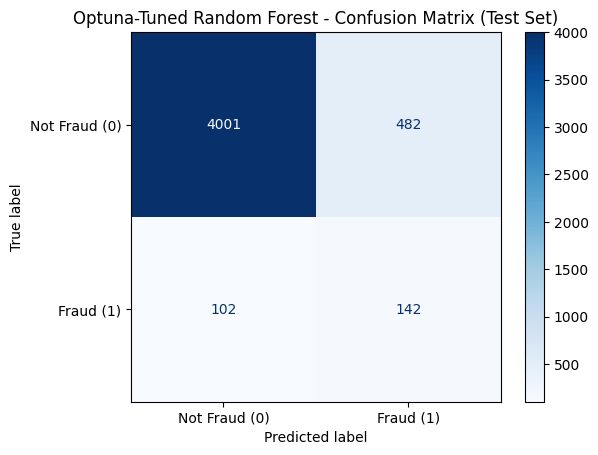

In [20]:
print("\n--- Evaluation of Best Model (Test Set) ---")
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Accuracy (Test Set): {accuracy:.4f}")
print(f"ROC-AUC Score (Test Set): {roc_auc:.4f}")

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, target_names=['Not Fraud (0)', 'Fraud (1)']))

# Confusion Matrix
print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud (0)', 'Fraud (1)'])
disp.plot(cmap='Blues')
plt.title("Optuna-Tuned Random Forest - Confusion Matrix (Test Set)")
plt.show()

In [21]:
print("\n--- Top 10 Feature Importances (Tuned Model) ---")
importances = best_rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df.head(10))


--- Top 10 Feature Importances (Tuned Model) ---
                feature  importance
3      Account Age Days    0.375500
6        is_new_account    0.358038
0    Transaction Amount    0.212773
11     amount_deviation    0.037154
2          Customer Age    0.003474
1              Quantity    0.002966
7   Transaction Weekday    0.002755
9       Transaction Day    0.001753
4      Transaction Hour    0.001509
8            is_weekend    0.000551
